# Multimodal video search using CLIP and LanceDB
We used LanceDB to store frames every thirty seconds and the title of 13000+ videos, 5 random from each top category from the Youtube 8M dataset.
Then, we used the CLIP model to embed frames and titles together. With LanceDB, we can perform embedding, keyword, and SQL search on these videosjpg)

### Install dependencies

In [4]:
!pip install -q condacolab
import condacolab
condacolab.install()

!conda create -n py310 python=3.10 -y -q

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local/envs/py310

  added / updated specs:
    - python=3.10


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bzip2-1.0.8                |       hda65f42_8         254 KB  conda-forge
    ca-certificates-2025.8.3   |       hbd8a1cb_0         151 KB  conda-forge
    ld_impl_linux-64-2.44      |       h1423503_1         660 KB  conda-forge
    libexpat-2.7.1             |       hecca717_0          73 KB  conda-forge
    libffi-3.4.6               |       h2dba641_1          56 KB  conda-forge
    libgcc-15.1.0  

In [5]:
!conda run -n py310 pip install --quiet -U lancedb
!conda run -n py310 pip install --quiet gradio transformers torch torchvision duckdb
!conda run -n py310 pip install tantivy==0.20.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 53.7 MB/s  0:00:00



## First run setup: Download data and pre-process

In [2]:
import duckdb
import lancedb

In [3]:
!wget https://vectordb-recipes.s3.us-west-2.amazonaws.com/multimodal_video_lance.tar.gz
!tar -xvf multimodal_video_lance.tar.gz
!mkdir -p data/video-lancedb
!mv multimodal_video.lance data/video-lancedb/

--2025-09-18 18:26:25--  https://vectordb-recipes.s3.us-west-2.amazonaws.com/multimodal_video_lance.tar.gz
Resolving vectordb-recipes.s3.us-west-2.amazonaws.com (vectordb-recipes.s3.us-west-2.amazonaws.com)... 3.5.77.185, 52.92.241.66, 3.5.78.17, ...
Connecting to vectordb-recipes.s3.us-west-2.amazonaws.com (vectordb-recipes.s3.us-west-2.amazonaws.com)|3.5.77.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239974228 (229M) [application/x-gzip]
Saving to: ‘multimodal_video_lance.tar.gz.1’

multimodal_video_la 100%[===================>] 228.86M  10.3MB/s    in 16s     

2025-09-18 18:26:41 (14.5 MB/s) - ‘multimodal_video_lance.tar.gz.1’ saved [239974228/239974228]

multimodal_video.lance/
multimodal_video.lance/.DS_Store
multimodal_video.lance/_versions/
multimodal_video.lance/_latest.manifest
multimodal_video.lance/data/
multimodal_video.lance/_indices/
multimodal_video.lance/_indices/tantivy/
multimodal_video.lance/_indices/tantivy/9b278a8cf1c14b7f8c4c92a4

## Create / Open LanceDB Table

In [6]:
db = lancedb.connect("data/video-lancedb")
tbl = db.open_table("multimodal_video")

## Create CLIP embedding function for the text
![clip](https://miro.medium.com/v2/resize:fit:3662/1*tg7akErlMSyCLQxrMtQIYw.png)
*CLIP model Architecuture.*

In [7]:
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast

MODEL_ID = "openai/clip-vit-base-patch32"

tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID)
processor = CLIPProcessor.from_pretrained(MODEL_ID)


def embed_func(query):
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    return text_features.detach().numpy()[0]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

## Search functions for Gradio

In [8]:
def find_video_vectors(query):
    emb = embed_func(query)
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"embedding = embed_func('{query}')\n"
        "tbl.search(embedding).limit(9).to_pandas()"
    )
    return (_extract(tbl.search(emb).limit(9).to_pandas()), code)


# function to find the search for the video keywords from lancedb
def find_video_keywords(query):
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"tbl.search('{query}').limit(9).to_pandas()"
    )
    return (_extract(tbl.search(query).limit(9).to_pandas()), code)


# create a SQL command to retrieve the video from the db
def find_video_sql(query):
    code = (
        "import lancedb\n"
        "import duckdb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        "videos = tbl.to_lance()\n"
        f"duckdb.sql('{query}').to_pandas()"
    )
    videos = tbl.to_lance()
    return (_extract(duckdb.sql(query).to_pandas()), code)


# extract the video from the df
def _extract(df):
    video_id_col = "video_id"
    start_time_col = "start_time"
    grid_html = '<div style="display: grid; grid-template-columns: repeat(3, 1fr); grid-gap: 20px;">'

    for _, row in df.iterrows():
        iframe_code = f'<iframe width="100%" height="315" src="https://www.youtube.com/embed/{row[video_id_col]}?start={str(row[start_time_col])}" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
        grid_html += f'<div style="width: 100%;">{iframe_code}</div>'

    grid_html += "</div>"
    return grid_html

In [9]:
def find_video_vectors(query):
    emb = embed_func(query)
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"embedding = embed_func('{query}')\n"
        "tbl.search(embedding).limit(9).to_pandas()"
    )
    return (_extract(tbl.search(emb).limit(9).to_pandas()), code)


def find_video_keywords(query):
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"tbl.search('{query}').limit(9).to_pandas()"
    )
    return (_extract(tbl.search(query).limit(9).to_pandas()), code)


def find_video_sql(query):
    code = (
        "import lancedb\n"
        "import duckdb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        "videos = tbl.to_lance()\n"
        f"duckdb.sql('{query}').to_pandas()"
    )
    videos = tbl.to_lance()
    return (_extract(duckdb.sql(query).to_pandas()), code)


def _extract(df):
    video_id_col = "video_id"
    start_time_col = "start_time"
    grid_html = '<div style="display: grid; grid-template-columns: repeat(3, 1fr); grid-gap: 20px;">'

    for _, row in df.iterrows():
        iframe_code = f'<iframe width="100%" height="315" src="https://www.youtube.com/embed/{row[video_id_col]}?start={str(row[start_time_col])}" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
        grid_html += f'<div style="width: 100%;">{iframe_code}</div>'

    grid_html += "</div>"
    return grid_html

## Setup Gradio interface
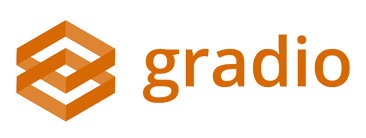

In [10]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown(
        """
            # Multimodal video search using CLIP and LanceDB
            We used LanceDB to store frames every thirty seconds and the title of 13000+ videos, 5 random from each top category from the Youtube 8M dataset.
            Then, we used the CLIP model to embed frames and titles together. With LanceDB, we can perform embedding, keyword, and SQL search on these videos.
            """
    )
    with gr.Row():
        with gr.Tab("Embeddings"):
            vector_query = gr.Textbox(value="retro gaming", show_label=False)
            b1 = gr.Button("Submit")
        with gr.Tab("Keywords"):
            keyword_query = gr.Textbox(value="ninja turtles", show_label=False)
            b2 = gr.Button("Submit")
        with gr.Tab("SQL"):
            sql_query = gr.Textbox(
                value="SELECT DISTINCT video_id, * from videos WHERE start_time > 0 LIMIT 9",
                show_label=False,
            )
            b3 = gr.Button("Submit")
    with gr.Row():
        code = gr.Code(label="Code", language="python")
    with gr.Row():
        gallery = gr.HTML()

    b1.click(find_video_vectors, inputs=vector_query, outputs=[gallery, code])
    b2.click(find_video_keywords, inputs=keyword_query, outputs=[gallery, code])
    b3.click(find_video_sql, inputs=sql_query, outputs=[gallery, code])

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9e77f0361545e16880.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
